# ARTIFICIAL INTELLIGENCE PROJECT
## Student: Santello Veronica 870320
## Date: January 2022

# CLASSIFICATION OF ROAD SIGNS

## Convolutional Neural Network Using SVM as Final Layer

In [1]:
# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.regularizers import l2

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Part 1 - Data Preprocessing


In [2]:
# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


In [3]:
training_set = train_datagen.flow_from_directory('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 788 images belonging to 4 classes.
Found 441 images belonging to 4 classes.


### Part 2 - Building the CNN

In [4]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer 
cnn.add(Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))


In [5]:
# Compiling the CNN    
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [6]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5

### Part 3 - Training the CNN

In [7]:
from timeit import default_timer as timer
from tensorflow import keras

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [8]:
# Training the CNN on the Training set and evaluating it on the Test set
cb = TimingCallback()
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 15, callbacks=[cb])

Epoch 1/15
25/25 [==============================] - 6s 252ms/step - loss: 1.0943 - accuracy: 0.6345 - val_loss: 1.0602 - val_accuracy: 0.6440
Epoch 2/15
25/25 [==============================] - 6s 234ms/step - loss: 0.9869 - accuracy: 0.6840 - val_loss: 1.0077 - val_accuracy: 0.6621
Epoch 3/15
25/25 [==============================] - 6s 236ms/step - loss: 0.8678 - accuracy: 0.7284 - val_loss: 0.9489 - val_accuracy: 0.6621
Epoch 4/15
25/25 [==============================] - 6s 237ms/step - loss: 0.7964 - accuracy: 0.7551 - val_loss: 0.9930 - val_accuracy: 0.7075
Epoch 5/15
25/25 [==============================] - 6s 238ms/step - loss: 0.7347 - accuracy: 0.7855 - val_loss: 0.8466 - val_accuracy: 0.7256
Epoch 6/15
25/25 [==============================] - 6s 242ms/step - loss: 0.7113 - accuracy: 0.7970 - val_loss: 0.8195 - val_accuracy: 0.7347
Epoch 7/15
25/25 [==============================] - 6s 231ms/step - loss: 0.6297 - accuracy: 0.8084 - val_loss: 0.8012 - val_accuracy: 0.7619
Epoch 

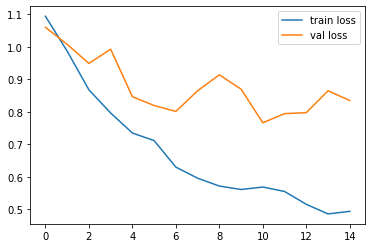

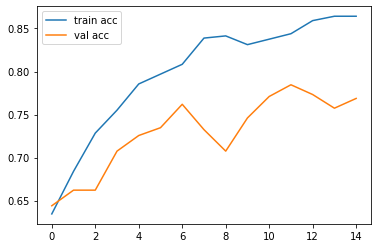

In [9]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### Part 4 - Predictions

In [10]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
from tensorflow.keras.preprocessing import image
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

images_path=glob.glob('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred/pred/*')

pred_dict={}
l = []
res = " "

for i in images_path:
    test_image = image.load_img(i, target_size = (64,64))
    test_image = image.img_to_array(test_image)
    test_image=test_image/255
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image)
    
    index = np.argmax(result)
    if(index == 0):
        res = "crosswalk"
    if(index == 1):
        res = "speedlimit"
    if(index == 2):
        res = "stop"
    if(index == 3):
        res = "trafficlight"
        
    pred_dict[i[i.rfind('/')+1:]]=res    
    l = l + [res]
    
    
    
transformer1 =  transforms.Compose([
                transforms.Resize((150,150)),
                transforms.ToTensor(),  
                transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] with formula (x - mean)/std
                                    [0.5,0.5,0.5])
])    
    
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   
    

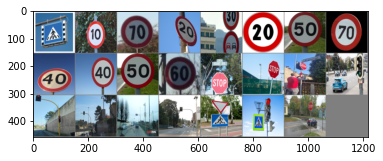

In [11]:
# Print images labelled with "speedlimit"
flag = []

for label in l:
    if (label == 'speedlimit'):
        flag += [1]
    else:
        flag += [0]

predset =  torchvision.datasets.ImageFolder('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred',transform=transformer1)
predloader = torch.utils.data.DataLoader(predset, batch_size=100,
                                         shuffle=False, num_workers=4)

dataiter = iter(predloader)
images, labels = dataiter.next()
images1 = []

for i in range(0,len(flag)):
    if(flag[i] == 1):
        images1 = images1 + [images[i]]


# print images
imshow(torchvision.utils.make_grid(images1))

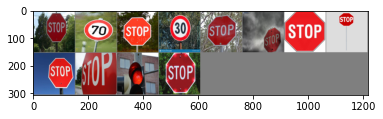

In [12]:
# Print images labelled with "stop"
flag = []

for label in l:
    if (label == 'stop'):
        flag += [1]
    else:
        flag += [0]

predset =  torchvision.datasets.ImageFolder('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred',transform=transformer1)
predloader = torch.utils.data.DataLoader(predset, batch_size=100,
                                         shuffle=False, num_workers=4)

dataiter = iter(predloader)
images, labels = dataiter.next()
images1 = []

for i in range(0,len(flag)):
    if(flag[i] == 1):
        images1 = images1 + [images[i]]


# print images
imshow(torchvision.utils.make_grid(images1))

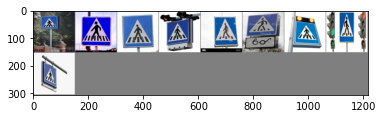

In [13]:
# Print images labelled with "crosswalk"
flag = []

for label in l:
    if (label == 'crosswalk'):
        flag += [1]
    else:
        flag += [0]

predset =  torchvision.datasets.ImageFolder('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred',transform=transformer1)
predloader = torch.utils.data.DataLoader(predset, batch_size=100,
                                         shuffle=False, num_workers=4)

dataiter = iter(predloader)
images, labels = dataiter.next()
images1 = []

for i in range(0,len(flag)):
    if(flag[i] == 1):
        images1 = images1 + [images[i]]


# print images
imshow(torchvision.utils.make_grid(images1))

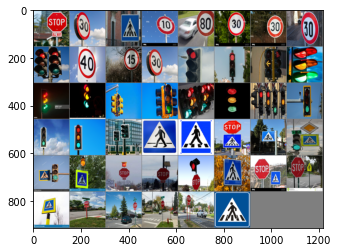

In [14]:
# Print images labelled with "trafficlight"
flag = []

for label in l:
    if (label == 'trafficlight'):
        flag += [1]
    else:
        flag += [0]

predset =  torchvision.datasets.ImageFolder('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred',transform=transformer1)
predloader = torch.utils.data.DataLoader(predset, batch_size=100,
                                         shuffle=False, num_workers=4)

dataiter = iter(predloader)
images, labels = dataiter.next()
images1 = []

for i in range(0,len(flag)):
    if(flag[i] == 1):
        images1 = images1 + [images[i]]


# print images
imshow(torchvision.utils.make_grid(images1))

## Convolutional Neural Network Using Fully Connected as Final Layer

In [15]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer 
cnn.add(tf.keras.layers.Dense(units=4, activation='sigmoid'))

In [16]:
# Compiling the CNN    
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [18]:
# Training the CNN on the Training set and evaluating it on the Test set
cb1 = TimingCallback()
r1=cnn.fit(x = training_set, validation_data = test_set, epochs = 15,callbacks=[cb1])

Epoch 1/15
25/25 [==============================] - 6s 242ms/step - loss: 1.0371 - accuracy: 0.6637 - val_loss: 1.0352 - val_accuracy: 0.6349
Epoch 2/15
25/25 [==============================] - 6s 233ms/step - loss: 0.9336 - accuracy: 0.6612 - val_loss: 0.9718 - val_accuracy: 0.6417
Epoch 3/15
25/25 [==============================] - 6s 233ms/step - loss: 0.8765 - accuracy: 0.6726 - val_loss: 0.9590 - val_accuracy: 0.6463
Epoch 4/15
25/25 [==============================] - 6s 234ms/step - loss: 0.8152 - accuracy: 0.6853 - val_loss: 0.9053 - val_accuracy: 0.6417
Epoch 5/15
25/25 [==============================] - 6s 235ms/step - loss: 0.7880 - accuracy: 0.6840 - val_loss: 0.9164 - val_accuracy: 0.6395
Epoch 6/15
25/25 [==============================] - 6s 234ms/step - loss: 0.7317 - accuracy: 0.6929 - val_loss: 0.8318 - val_accuracy: 0.6463
Epoch 7/15
25/25 [==============================] - 6s 234ms/step - loss: 0.7197 - accuracy: 0.7005 - val_loss: 0.8458 - val_accuracy: 0.6508
Epoch 

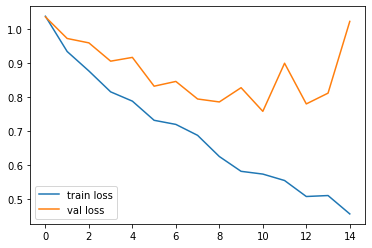

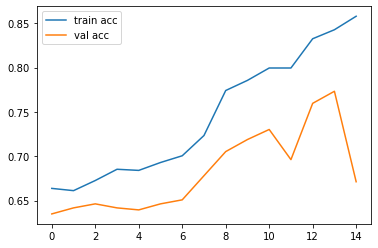

In [19]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [20]:
images_path=glob.glob('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred/pred/*')

pred_dict={}
l = []
res = " "

for i in images_path:
    test_image = image.load_img(i, target_size = (64,64))
    test_image = image.img_to_array(test_image)
    test_image=test_image/255
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image)
    
    index = np.argmax(result)
    if(index == 0):
        res = "crosswalk"
    if(index == 1):
        res = "speedlimit"
    if(index == 2):
        res = "stop"
    if(index == 3):
        res = "trafficlight"
        
    pred_dict[i[i.rfind('/')+1:]]=res    
    l = l + [res]
    
    
    
transformer1 =  transforms.Compose([
                transforms.Resize((150,150)),
                transforms.ToTensor(),  
                transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] with formula (x - mean)/std
                                    [0.5,0.5,0.5])
])    
    
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

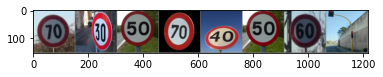

In [21]:
# Print images labelled with "speedlimit"
flag = []

for label in l:
    if (label == 'speedlimit'):
        flag += [1]
    else:
        flag += [0]

predset =  torchvision.datasets.ImageFolder('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred',transform=transformer1)
predloader = torch.utils.data.DataLoader(predset, batch_size=100,
                                         shuffle=False, num_workers=4)

dataiter = iter(predloader)
images, labels = dataiter.next()
images1 = []

for i in range(0,len(flag)):
    if(flag[i] == 1):
        images1 = images1 + [images[i]]


# print images
imshow(torchvision.utils.make_grid(images1))


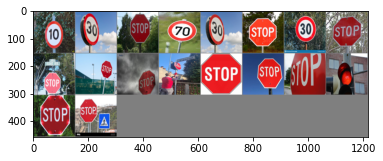

In [22]:
# Print images labelled with "stop"
flag = []

for label in l:
    if (label == 'stop'):
        flag += [1]
    else:
        flag += [0]

predset =  torchvision.datasets.ImageFolder('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred',transform=transformer1)
predloader = torch.utils.data.DataLoader(predset, batch_size=100,
                                         shuffle=False, num_workers=4)

dataiter = iter(predloader)
images, labels = dataiter.next()
images1 = []

for i in range(0,len(flag)):
    if(flag[i] == 1):
        images1 = images1 + [images[i]]


# print images
imshow(torchvision.utils.make_grid(images1))

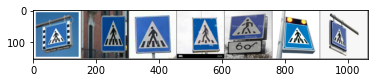

In [23]:
# Print images labelled with "crosswalk"
flag = []

for label in l:
    if (label == 'crosswalk'):
        flag += [1]
    else:
        flag += [0]

predset =  torchvision.datasets.ImageFolder('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred',transform=transformer1)
predloader = torch.utils.data.DataLoader(predset, batch_size=100,
                                         shuffle=False, num_workers=4)

dataiter = iter(predloader)
images, labels = dataiter.next()
images1 = []

for i in range(0,len(flag)):
    if(flag[i] == 1):
        images1 = images1 + [images[i]]


# print images
imshow(torchvision.utils.make_grid(images1))

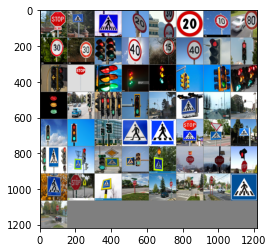

In [24]:
# Print images labelled with "trafficlight"
flag = []

for label in l:
    if (label == 'trafficlight'):
        flag += [1]
    else:
        flag += [0]

predset =  torchvision.datasets.ImageFolder('C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images1/pred',transform=transformer1)
predloader = torch.utils.data.DataLoader(predset, batch_size=100,
                                         shuffle=False, num_workers=4)

dataiter = iter(predloader)
images, labels = dataiter.next()
images1 = []

for i in range(0,len(flag)):
    if(flag[i] == 1):
        images1 = images1 + [images[i]]


# print images
imshow(torchvision.utils.make_grid(images1))

## Comparisons

### Traning data

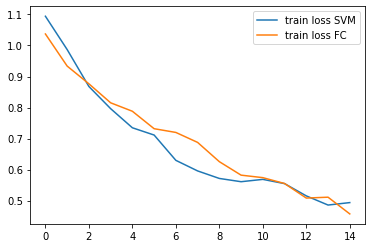

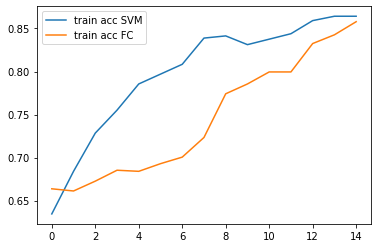

In [25]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss SVM')
plt.plot(r1.history['loss'], label='train loss FC')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc SVM')
plt.plot(r1.history['accuracy'], label='train acc FC')
plt.legend()
plt.show()

### Valuation data

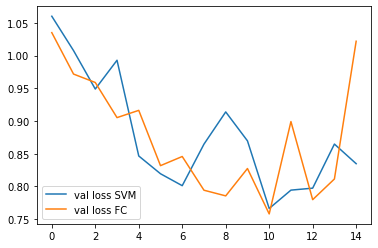

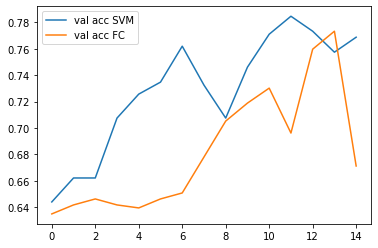

In [26]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['val_loss'], label='val loss SVM')
plt.plot(r1.history['val_loss'], label='val loss FC')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['val_accuracy'], label='val acc SVM')
plt.plot(r1.history['val_accuracy'], label='val acc FC')
plt.legend()
plt.show()

### Execution time

In [28]:
cumulative = np.cumsum(cb.logs)
cumulative1 = np.cumsum(cb1.logs)

In [29]:
from tabulate import tabulate
print(tabulate({'Epoch': range(1,16),'CNN - FC': cumulative1, 'CNN - SVM': cumulative}, headers="keys", tablefmt='fancy_grid'))


╒═════════╤════════════╤═════════════╕
│   Epoch │   CNN - FC │   CNN - SVM │
╞═════════╪════════════╪═════════════╡
│       1 │    6.65659 │      6.8729 │
├─────────┼────────────┼─────────────┤
│       2 │   12.6661  │     12.8634 │
├─────────┼────────────┼─────────────┤
│       3 │   18.6789  │     18.8577 │
├─────────┼────────────┼─────────────┤
│       4 │   24.7059  │     24.9782 │
├─────────┼────────────┼─────────────┤
│       5 │   30.7407  │     31.0929 │
├─────────┼────────────┼─────────────┤
│       6 │   36.759   │     37.3122 │
├─────────┼────────────┼─────────────┤
│       7 │   42.7732  │     43.3913 │
├─────────┼────────────┼─────────────┤
│       8 │   48.7786  │     49.5726 │
├─────────┼────────────┼─────────────┤
│       9 │   54.7844  │     55.6324 │
├─────────┼────────────┼─────────────┤
│      10 │   60.8925  │     61.7085 │
├─────────┼────────────┼─────────────┤
│      11 │   67.0093  │     67.834  │
├─────────┼────────────┼─────────────┤
│      12 │   73.1139  │ 